Magnetic

In [1]:
%pylab inline
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Concatenate, InputLayer, Input, Layer

Populating the interactive namespace from numpy and matplotlib


In [2]:
dataset=pd.read_csv("Wolverton_ABO3_perovskites.csv")

In [3]:
dataset.loc[dataset["Magnetic moment [mu_B]"]=="-","Magnetic moment [mu_B]"]=0.0
dataset["Magnetic moment [mu_B]"]=dataset["Magnetic moment [mu_B]"].astype(float)

In [4]:
dataset.loc[dataset["Magnetic moment [mu_B]"].abs()<=1e-2,"is_magnetic"]=False

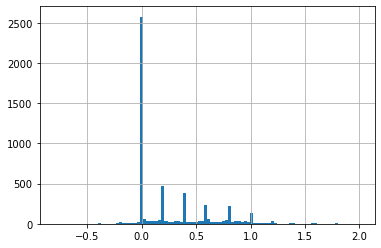

In [5]:
dataset.loc[dataset["Magnetic moment [mu_B]"].abs()>1e-2,"is_magnetic"]=True
dataset["Magnetic moment [mu_B]"].hist(bins=100);

In [6]:
dataset=dataset.drop(columns="Vacancy energy [eV/O atom]")
dataset=dataset[~dataset[dataset=="-"].any(axis=1)]
dataset.shape

(5276, 21)

In [7]:
dataset=dataset[dataset["Formation energy [eV/atom]"]!="-"].copy()

In [8]:
dataset["Formation energy [eV/atom]"]=dataset["Formation energy [eV/atom]"].astype(float)

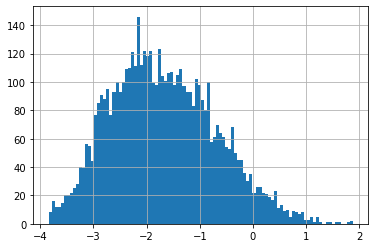

In [9]:
dataset["Formation energy [eV/atom]"].hist(bins=100);

In [10]:
dataset["Stability [eV/atom]"]=dataset["Stability [eV/atom]"].astype(float)
dataset["Volume per atom [A^3/atom]"]=dataset["Volume per atom [A^3/atom]"].astype(float)

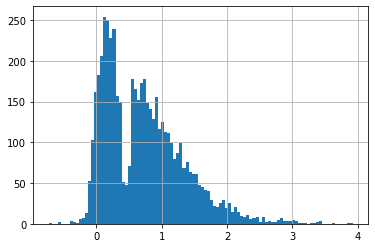

In [11]:
dataset["Stability [eV/atom]"].hist(bins=100);

In [12]:
dataset["is_magnetic"].value_counts()

True     2775
False    2501
Name: is_magnetic, dtype: int64

In [13]:
dataset["is_ns"]=dataset["Stability [eV/atom]"]>0.5

In [14]:
dataset["is_ns"].value_counts()

True     3145
False    2131
Name: is_ns, dtype: int64

In [15]:
dataset["AB_tuple"]=dataset.apply(lambda r: (r["A"],r["B"]), axis=1)

### OneHotEncoder()

In [86]:
ohe=OneHotEncoder()

In [87]:
elements = np.array(sorted(set(dataset["A"]) | set(dataset["B"])))

In [88]:
NUM_OF_ELEMENTS = len(elements)
NUM_OF_ELEMENTS

73

In [162]:
ohe.fit(elements.reshape(-1,1));

In [163]:
np.random.seed(42)
dataset["is_train"]=np.random.rand(len(dataset))>0.5

In [214]:
ds_train=dataset[dataset["is_train"]]
ds_test=dataset[~dataset["is_train"]]

In [215]:
oheA_labels_train=ohe.transform(ds_train["A"].values.reshape(-1,1)).toarray()
oheA_labels_test=ohe.transform(ds_test["A"].values.reshape(-1,1)).toarray()

In [216]:
oheB_labels_train = ohe.transform(ds_train["B"].values.reshape(-1,1)).toarray()
oheB_labels_test  = ohe.transform(ds_test["B"].values.reshape(-1,1)).toarray()

In [217]:
is_magnetic_train=ds_train["is_magnetic"].astype(float)
is_magnetic_test=ds_test["is_magnetic"].astype(float)

In [218]:
is_ns_train = ds_train["is_ns"].astype(float)
is_ns_test  = ds_test["is_ns"].astype(float)

In [219]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a sample."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim),  dtype=tf.float32)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [220]:
latent_dim=25 # latent dimension space
dense_dim=[300,200,100,50] # number of neurons in hidden layers

In [239]:
# four inputs: ele A, ele B, is_stable, is_magnetic#
from tensorflow.keras.layers import Dense, LeakyReLU, Activation


inp_A_OHE = Input(shape=(NUM_OF_ELEMENTS,), name="inp_A_OHE")
inp_B_OHE = Input(shape=(NUM_OF_ELEMENTS,), name="inp_B_OHE")
inp_is_ns = Input(shape=(1,), name="inp_is_ns")
inp_is_magnetic = Input(shape=(1,), name="inp_is_magnetic")

# glue all four inputs together
concat_input = Concatenate(name="concat_inp")([inp_A_OHE,inp_B_OHE,inp_is_ns,inp_is_magnetic])

In [293]:
# encoder part (simple fully connected NN)
d1=Dense(dense_dim[0], activation="selu",name="encoder_dense1")(concat_input)
d2=Dense(dense_dim[1], activation="selu",name="encoder_dense2")(d1)
d3=Dense(dense_dim[2], activation="tanh",name="encoder_dense3")(d2)
d4=Dense(dense_dim[2], activation="tanh",name="encoder_dense4")(d3)

z_mean = Dense(latent_dim, name="z_mean")(d4)
z_log_var = Dense(latent_dim, name="z_log_var")(d4)

# one of the output of encoder: randomly sampled latent variable Z
z = Sampling(name="z_sampling")([z_mean, z_log_var])

In [294]:
encoder = Model(
    # four inputs
    inputs=[inp_A_OHE, inp_B_OHE, inp_is_magnetic, inp_is_ns],
    
    # three outputs, but z depends on z_mean and z_log_var
    outputs=[z_mean, z_log_var, z], 
    
    name="encoder"
)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_A_OHE (InputLayer)          [(None, 73)]         0                                            
__________________________________________________________________________________________________
inp_B_OHE (InputLayer)          [(None, 73)]         0                                            
__________________________________________________________________________________________________
inp_is_ns (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
inp_is_magnetic (InputLayer)    [(None, 1)]          0                                            
____________________________________________________________________________________________

In [295]:
z_input =Input(shape=(latent_dim,), name="inpd_z")

In [296]:
concat_input_decoder = Concatenate(name="decoder_concat_input")([z_input, inp_is_magnetic, inp_is_ns])

In [297]:
from tensorflow.keras.layers import Dense, LeakyReLU, Activation


d1 = Dense(dense_dim[0], activation="selu", name="decoder_dense1")(concat_input_decoder)
 # ELU activation here SELU
d2 = Dense(dense_dim[1], activation="selu", name="decoder_dense2")(d1)
d3 = Dense(dense_dim[2], activation="tanh", name="decoder_dense3")(d2)
d4 = Dense(dense_dim[3], activation="tanh", name="decoder_dense4")(d3)




In [298]:
out_A_OHE = Dense(NUM_OF_ELEMENTS, activation="softmax", name="out_A_OHE")(d4)
out_B_OHE = Dense(NUM_OF_ELEMENTS, activation="softmax", name="out_B_OHE")(d4)

In [299]:
decoder = Model(
        inputs=[z_input, inp_is_magnetic, inp_is_ns], 
        outputs=[out_A_OHE, out_B_OHE], 
        name="decoder") 

# summary
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inpd_z (InputLayer)             [(None, 25)]         0                                            
__________________________________________________________________________________________________
inp_is_magnetic (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
inp_is_ns (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
decoder_concat_input (Concatena (None, 27)           0           inpd_z[0][0]                     
                                                                 inp_is_magnetic[0][0]      

In [300]:
class ConditionalVAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(ConditionalVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    # custom train step
    def train_step(self, data):
        # split data tuple into (inp)ut and (out)put
        inp, out = data 
        # split inp and out into four inputs and two outputs further 
        [inp_A_OHE, inp_A_OHE,  inp_is_magnetic, inp_is_ns] = inp
        [out_A_OHE_true, out_B_OHE_true] = out
        
        with tf.GradientTape() as tape:

            # run encoder with inp, get three outputs            
            z_mean, z_log_var, z = self.encoder(inp) 
            
            # pass latent variable "z" and two conditional variables inp_is_magnetic, inp_is_stable intp decoder
            out_A_OHE, out_B_OHE = self.decoder([z, inp_is_magnetic, inp_is_ns])

            # now important part: custom loss function
            # 1) reconstruction loss: mean squared error and cross entropy.
            reconstruction_loss =\
                tf.reduce_mean(keras.losses.categorical_crossentropy(out_A_OHE, out_A_OHE_true))+\
                tf.reduce_mean(keras.losses.categorical_crossentropy(out_B_OHE, out_B_OHE_true))
            
            # 2)  Kullback–Leibler divergence: distance loss between the two distributions
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss, axis=1)
            
            # 3) total loss is sum of two losses
            total_loss = tf.cast(reconstruction_loss,dtype=tf.float64) + tf.cast(kl_loss,dtype=tf.float64)
            
        # now take the gradien of total_loss wrt. trainable parameters
        grads = tape.gradient(total_loss, self.trainable_weights)
       
        # apply this gradients to update trainable_weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # update current losses
        self.total_loss_tracker.update_state(total_loss)        
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        # return current losses in some special format
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    # custom test step
    def test_step(self, data):
        # split data tuple into (inp)ut and (out)put
        inp, out = data 
        
        # split inp and out into four inputs and two outputs further 
        [inp_A_OHE, inp_A_OHE,  inp_is_magnetic, inp_is_ns] = inp
        [out_A_OHE_true, out_B_OHE_true] = out
        
        # run encoder with inp, get three outputs            
        z_mean, z_log_var, z = self.encoder(inp) 

        # pass latent variable "z" and two conditional variables inp_is_magnetic, inp_is_stable intp decoder
        out_A_OHE, out_B_OHE = self.decoder([z, inp_is_magnetic, inp_is_ns])

        # now important part: custom loss function
        # 1) reconstruction loss: mean squared error and cross entropy.
        reconstruction_loss =\
            tf.reduce_mean(keras.losses.categorical_crossentropy(out_A_OHE, out_A_OHE_true))+\
            tf.reduce_mean(keras.losses.categorical_crossentropy(out_B_OHE, out_B_OHE_true))

        # 2)  Kullback–Leibler divergence: distance loss between the two distributions
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss, axis=1)

        # 3) total loss is sum of two losses
        total_loss = tf.cast(reconstruction_loss,dtype=tf.float64) + tf.cast(kl_loss,dtype=tf.float64)
        
        # update current losses
        self.total_loss_tracker.update_state(total_loss)        
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        # return current losses in some special format
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [301]:
cvae=ConditionalVAE(encoder, decoder)

In [302]:
cvae.compile(optimizer="adam")

In [303]:
es=EarlyStopping(patience=150, mode="min")

In [312]:
np.random.seed(42)

cvae.fit(
    # four inputs of encoder
    x = [oheA_labels_train, oheB_labels_train,  is_magnetic_train, is_ns_train],    
    
    # two outputs of decoder
    y = [oheA_labels_train, oheB_labels_train],
    
    # 15% split for validations
    validation_split=0.15,
    
    # batch size
    batch_size=128,
    
    # many epochs 
    epochs=1000,
    # early stopping is used
    callbacks=[es],
    
    # verbosity level
    verbose=2,
)

Epoch 1/1000
18/18 - 0s - loss: 3.2184 - reconstruction_loss: 2.0126 - kl_loss: 1.1148 - val_loss: 17.7616 - val_reconstruction_loss: 16.5104 - val_kl_loss: 1.1376
Epoch 2/1000
18/18 - 1s - loss: 3.0475 - reconstruction_loss: 1.9971 - kl_loss: 1.1058 - val_loss: 17.7478 - val_reconstruction_loss: 16.5070 - val_kl_loss: 1.1271
Epoch 3/1000
18/18 - 0s - loss: 3.1978 - reconstruction_loss: 1.9626 - kl_loss: 1.0985 - val_loss: 17.8481 - val_reconstruction_loss: 16.5884 - val_kl_loss: 1.1221
Epoch 4/1000
18/18 - 0s - loss: 3.1183 - reconstruction_loss: 1.9906 - kl_loss: 1.0983 - val_loss: 17.6724 - val_reconstruction_loss: 16.4530 - val_kl_loss: 1.1217
Epoch 5/1000
18/18 - 0s - loss: 3.0426 - reconstruction_loss: 1.9987 - kl_loss: 1.1060 - val_loss: 17.8417 - val_reconstruction_loss: 16.5752 - val_kl_loss: 1.1327
Epoch 6/1000
18/18 - 0s - loss: 3.1552 - reconstruction_loss: 2.0398 - kl_loss: 1.1089 - val_loss: 17.7977 - val_reconstruction_loss: 16.5437 - val_kl_loss: 1.1299
Epoch 7/1000
18/

Epoch 51/1000
18/18 - 0s - loss: 2.7557 - reconstruction_loss: 1.9192 - kl_loss: 1.0752 - val_loss: 17.7454 - val_reconstruction_loss: 16.5160 - val_kl_loss: 1.1134
Epoch 52/1000
18/18 - 1s - loss: 2.9301 - reconstruction_loss: 1.8177 - kl_loss: 1.1000 - val_loss: 17.7077 - val_reconstruction_loss: 16.4743 - val_kl_loss: 1.1291
Epoch 53/1000
18/18 - 0s - loss: 2.8299 - reconstruction_loss: 1.7837 - kl_loss: 1.1098 - val_loss: 17.8190 - val_reconstruction_loss: 16.5540 - val_kl_loss: 1.1376
Epoch 54/1000
18/18 - 0s - loss: 2.8912 - reconstruction_loss: 1.7755 - kl_loss: 1.1136 - val_loss: 17.7302 - val_reconstruction_loss: 16.4851 - val_kl_loss: 1.1377
Epoch 55/1000
18/18 - 0s - loss: 2.9043 - reconstruction_loss: 1.6972 - kl_loss: 1.1042 - val_loss: 17.7766 - val_reconstruction_loss: 16.5357 - val_kl_loss: 1.1186
Epoch 56/1000
18/18 - 0s - loss: 2.6570 - reconstruction_loss: 1.7579 - kl_loss: 1.0887 - val_loss: 17.6908 - val_reconstruction_loss: 16.4839 - val_kl_loss: 1.1010
Epoch 57/1

Epoch 101/1000
18/18 - 0s - loss: 2.7911 - reconstruction_loss: 1.6653 - kl_loss: 1.0833 - val_loss: 17.6790 - val_reconstruction_loss: 16.4852 - val_kl_loss: 1.1016
Epoch 102/1000
18/18 - 0s - loss: 2.6839 - reconstruction_loss: 1.6916 - kl_loss: 1.0851 - val_loss: 17.6119 - val_reconstruction_loss: 16.4235 - val_kl_loss: 1.1061
Epoch 103/1000
18/18 - 1s - loss: 2.6881 - reconstruction_loss: 1.6358 - kl_loss: 1.0895 - val_loss: 17.6477 - val_reconstruction_loss: 16.4459 - val_kl_loss: 1.1062
Epoch 104/1000
18/18 - 0s - loss: 2.6388 - reconstruction_loss: 1.6090 - kl_loss: 1.0862 - val_loss: 17.6117 - val_reconstruction_loss: 16.4260 - val_kl_loss: 1.0956
Epoch 105/1000
18/18 - 0s - loss: 2.6969 - reconstruction_loss: 1.6007 - kl_loss: 1.0770 - val_loss: 17.6306 - val_reconstruction_loss: 16.4409 - val_kl_loss: 1.0959
Epoch 106/1000
18/18 - 0s - loss: 2.6841 - reconstruction_loss: 1.6297 - kl_loss: 1.0851 - val_loss: 17.6262 - val_reconstruction_loss: 16.4329 - val_kl_loss: 1.1014
Epoc

Epoch 151/1000
18/18 - 0s - loss: 2.6443 - reconstruction_loss: 1.5627 - kl_loss: 1.0875 - val_loss: 17.5208 - val_reconstruction_loss: 16.3519 - val_kl_loss: 1.1006
Epoch 152/1000
18/18 - 0s - loss: 2.5923 - reconstruction_loss: 1.4884 - kl_loss: 1.0805 - val_loss: 17.4872 - val_reconstruction_loss: 16.3313 - val_kl_loss: 1.0936
Epoch 153/1000
18/18 - 1s - loss: 2.7007 - reconstruction_loss: 1.4703 - kl_loss: 1.0766 - val_loss: 17.5508 - val_reconstruction_loss: 16.3857 - val_kl_loss: 1.0868
Epoch 154/1000
18/18 - 0s - loss: 2.5809 - reconstruction_loss: 1.5248 - kl_loss: 1.0732 - val_loss: 17.4646 - val_reconstruction_loss: 16.3172 - val_kl_loss: 1.0891
Epoch 155/1000
18/18 - 0s - loss: 2.6022 - reconstruction_loss: 1.5353 - kl_loss: 1.0700 - val_loss: 17.4720 - val_reconstruction_loss: 16.3247 - val_kl_loss: 1.0868
Epoch 156/1000
18/18 - 0s - loss: 2.6714 - reconstruction_loss: 1.5044 - kl_loss: 1.0674 - val_loss: 17.4761 - val_reconstruction_loss: 16.3317 - val_kl_loss: 1.0819
Epoc

Epoch 201/1000
18/18 - 0s - loss: 2.6141 - reconstruction_loss: 1.5071 - kl_loss: 1.1046 - val_loss: 17.4721 - val_reconstruction_loss: 16.3042 - val_kl_loss: 1.1135
Epoch 202/1000
18/18 - 0s - loss: 2.6259 - reconstruction_loss: 1.4583 - kl_loss: 1.0910 - val_loss: 17.4974 - val_reconstruction_loss: 16.3271 - val_kl_loss: 1.1092
Epoch 203/1000
18/18 - 0s - loss: 2.5176 - reconstruction_loss: 1.4716 - kl_loss: 1.0970 - val_loss: 17.4669 - val_reconstruction_loss: 16.2981 - val_kl_loss: 1.1162
Epoch 204/1000
18/18 - 1s - loss: 2.6322 - reconstruction_loss: 1.4909 - kl_loss: 1.0976 - val_loss: 17.5041 - val_reconstruction_loss: 16.3291 - val_kl_loss: 1.1133
Epoch 205/1000
18/18 - 0s - loss: 2.4696 - reconstruction_loss: 1.5226 - kl_loss: 1.0993 - val_loss: 17.5043 - val_reconstruction_loss: 16.3256 - val_kl_loss: 1.1179
Epoch 206/1000
18/18 - 0s - loss: 2.5255 - reconstruction_loss: 1.4856 - kl_loss: 1.1032 - val_loss: 17.4762 - val_reconstruction_loss: 16.3043 - val_kl_loss: 1.1175
Epoc

Epoch 251/1000
18/18 - 0s - loss: 2.5884 - reconstruction_loss: 1.4992 - kl_loss: 1.0566 - val_loss: 17.4383 - val_reconstruction_loss: 16.3144 - val_kl_loss: 1.0664
Epoch 252/1000
18/18 - 0s - loss: 2.5152 - reconstruction_loss: 1.4993 - kl_loss: 1.0616 - val_loss: 17.4513 - val_reconstruction_loss: 16.3512 - val_kl_loss: 1.0794
Epoch 253/1000
18/18 - 0s - loss: 2.4026 - reconstruction_loss: 1.4283 - kl_loss: 1.0701 - val_loss: 17.4723 - val_reconstruction_loss: 16.3232 - val_kl_loss: 1.0891
Epoch 254/1000
18/18 - 1s - loss: 2.5745 - reconstruction_loss: 1.4281 - kl_loss: 1.0746 - val_loss: 17.4714 - val_reconstruction_loss: 16.3191 - val_kl_loss: 1.0935
Epoch 255/1000
18/18 - 0s - loss: 2.4080 - reconstruction_loss: 1.5100 - kl_loss: 1.0757 - val_loss: 17.5868 - val_reconstruction_loss: 16.4043 - val_kl_loss: 1.0990
Epoch 256/1000
18/18 - 0s - loss: 2.4084 - reconstruction_loss: 1.3806 - kl_loss: 1.0745 - val_loss: 17.4940 - val_reconstruction_loss: 16.3396 - val_kl_loss: 1.0897
Epoc

Epoch 301/1000
18/18 - 0s - loss: 2.3465 - reconstruction_loss: 1.3876 - kl_loss: 1.0781 - val_loss: 17.4995 - val_reconstruction_loss: 16.3416 - val_kl_loss: 1.0932
Epoch 302/1000
18/18 - 1s - loss: 2.4610 - reconstruction_loss: 1.3838 - kl_loss: 1.0724 - val_loss: 17.4899 - val_reconstruction_loss: 16.3354 - val_kl_loss: 1.0908
Epoch 303/1000
18/18 - 0s - loss: 2.5698 - reconstruction_loss: 1.3964 - kl_loss: 1.0734 - val_loss: 17.5201 - val_reconstruction_loss: 16.3550 - val_kl_loss: 1.0961
Epoch 304/1000
18/18 - 0s - loss: 2.5340 - reconstruction_loss: 1.3791 - kl_loss: 1.0798 - val_loss: 17.5652 - val_reconstruction_loss: 16.3926 - val_kl_loss: 1.0933
Epoch 305/1000
18/18 - 0s - loss: 2.4097 - reconstruction_loss: 1.4110 - kl_loss: 1.0678 - val_loss: 17.4640 - val_reconstruction_loss: 16.3249 - val_kl_loss: 1.0787
Epoch 306/1000
18/18 - 0s - loss: 2.3188 - reconstruction_loss: 1.3658 - kl_loss: 1.0622 - val_loss: 17.4606 - val_reconstruction_loss: 16.3251 - val_kl_loss: 1.0749
Epoc

Text(0, 0.5, 'Loss')

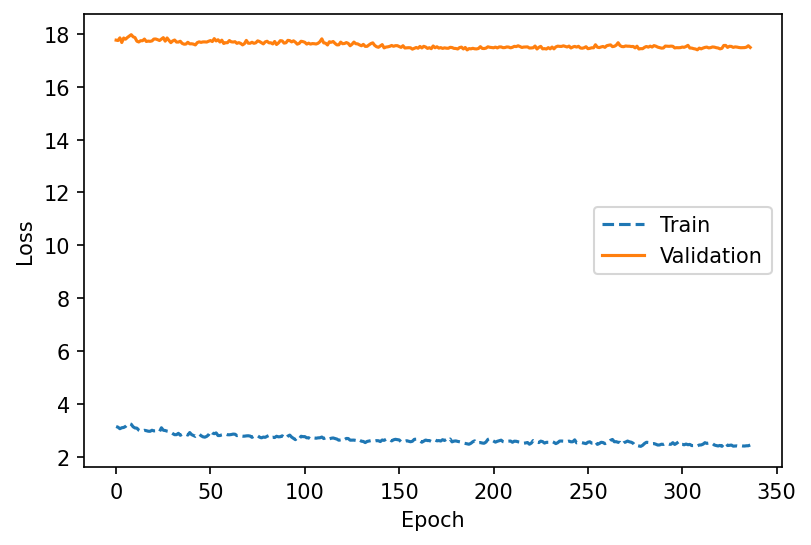

In [313]:
plt.figure(dpi=150)
plt.plot(cvae.history.history["loss"], ls="--", label="Train")
plt.plot(cvae.history.history["val_loss"], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")


Text(0, 0.5, 'Reconstruction Loss')

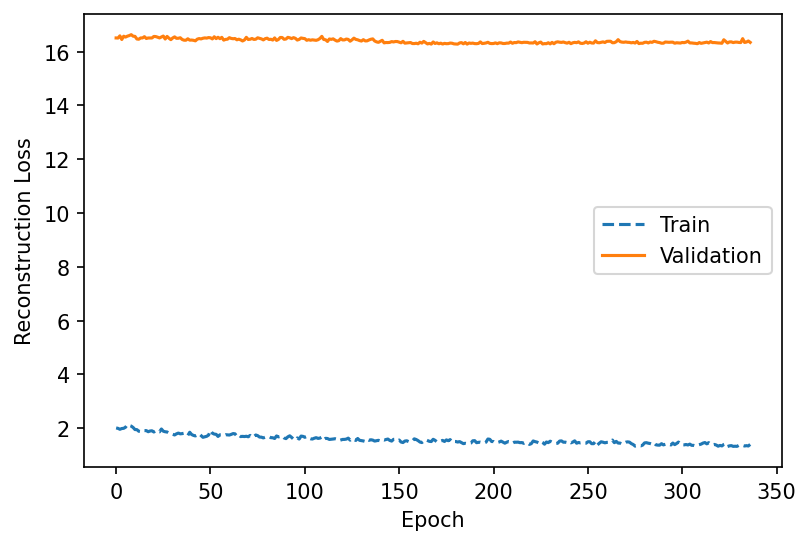

In [314]:
plt.figure(dpi=150)
plt.plot(cvae.history.history["reconstruction_loss"], ls="--", label="Train")
plt.plot(cvae.history.history["val_reconstruction_loss"], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")


Text(0, 0.5, 'Reconstruction Loss')

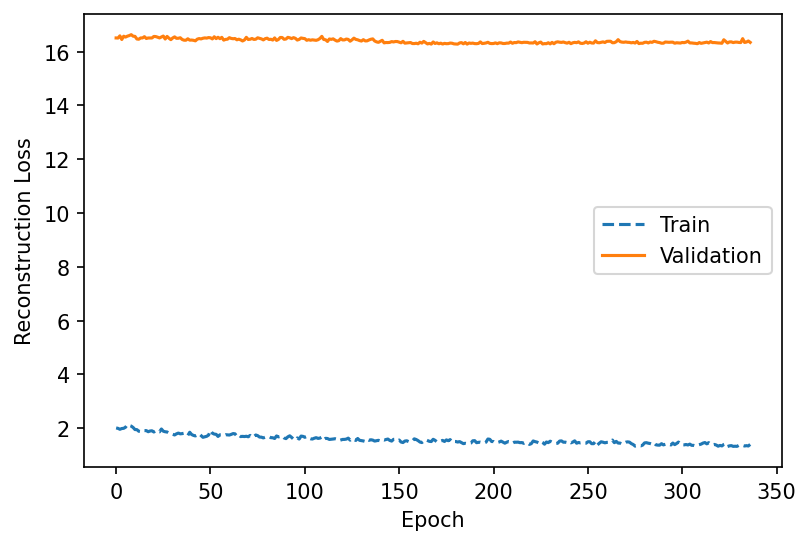

In [315]:
plt.figure(dpi=150)
plt.plot(cvae.history.history["reconstruction_loss"], ls="--", label="Train")
plt.plot(cvae.history.history["val_reconstruction_loss"], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")


Text(0, 0.5, 'KL-Loss')

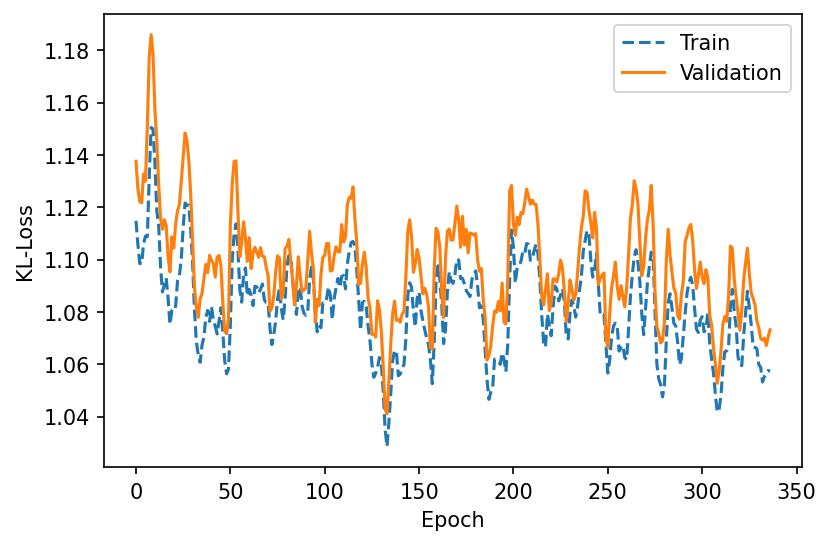

In [316]:
plt.figure(dpi=150)
plt.plot(cvae.history.history["kl_loss"], ls="--", label="Train")
plt.plot(cvae.history.history["val_kl_loss"], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("KL-Loss")


## Accuracy for A and B 

In [317]:
z_mean,z_log_var,z=encoder.predict([oheA_labels_train,
                                    oheB_labels_train,
                                    is_magnetic_train,is_ns_train])


# Generating predictions from the cVAE
from sklearn.metrics import confusion_matrix, f1_score

z_mean, z_log_var, z = encoder.predict([oheA_labels_test, oheB_labels_test, is_magnetic_test, is_ns_test])
out_A_OHE_pred, out_B_OHE_pred = decoder.predict([z, is_magnetic_test, is_ns_test])

y_pred_A = np.argmax(out_A_OHE_pred, axis=1)
y_pred_B = np.argmax(out_B_OHE_pred, axis=1)

y_true_A = np.argmax(oheA_labels_test, axis=1)
y_true_B = np.argmax(oheB_labels_test, axis=1)

accuracy_A = np.mean(y_true_A == y_pred_A)
accuracy_B = np.mean(y_true_B == y_pred_B)

print(f'Accuracy for A: {accuracy_A}')
print(f'Accuracy for B: {accuracy_B}')







Accuracy for A: 0.5778114350624763
Accuracy for B: 0.6565694812570996


In [318]:
ref_zmean = np.mean(z_mean, axis=0)
ref_zmean

array([ 0.04093483,  0.02388048,  0.01668776, -0.05607645,  0.01634252,
       -0.0145027 , -0.0796565 ,  0.07558987,  0.00595396, -0.08510551,
        0.054816  , -0.02393716,  0.03239068, -0.00307314, -0.00393997,
       -0.06575474, -0.0276444 ,  0.03614401, -0.07279015,  0.00862201,
       -0.02431214, -0.02165411,  0.06111805, -0.06621342, -0.01032582],
      dtype=float32)

In [319]:
ref_z_log_var = np.mean(z_log_var, axis=0)
ref_z_log_var

array([-0.15118308, -0.01259874, -0.16643013, -0.08199231, -3.5696325 ,
       -0.12868667, -3.2945259 , -3.4314783 , -3.3604474 , -3.1710315 ,
       -0.08643273, -3.3223114 , -0.11197512, -0.10434847, -3.440944  ,
       -3.421075  , -0.1073067 , -3.3547313 , -3.532945  , -3.1015546 ,
       -0.10998555, -3.4987535 , -3.0243273 , -3.4405088 , -3.6422994 ],
      dtype=float32)

In [48]:
def generate_predictions(z_input, is_magnetic=True, is_ns=True, element_ohe_threshold=0.5):
    
    predict_batch_size=z_input.shape[0]
    trues=np.ones(predict_batch_size)
    falses=np.zeros(predict_batch_size)
    # Generate new compositions by calling decoder part
    pred_stab_magn=decoder.predict([
                                    z_input,                                            
                                    trues if is_magnetic else  falses,  # is magnetic                               
                                    trues if is_ns else  falses,  # is stable                               
                                   ],batch_size=128)

    oheA_pred=pred_stab_magn[0]
    oheB_pred=pred_stab_magn[1]

    # Select only those elements, for which prob > element_ohe_threshold=0.5
    oheA_pred_crop=(oheA_pred>element_ohe_threshold).astype(int)
    oheB_pred_crop=(oheB_pred>element_ohe_threshold).astype(int)

    goodA_mask = np.any(oheA_pred_crop==1,axis=1)
    goodB_mask = np.any(oheB_pred_crop==1,axis=1)
    good_mask = goodA_mask & goodB_mask
    oheA_pred_correct=oheA_pred_crop[good_mask]
    oheB_pred_correct=oheB_pred_crop[good_mask]

    # inverse transform newly predicted A and B elements, converted it to elements name
    # and wrap it into DataFrame
    generated_df=pd.DataFrame(
                {
                    "A":ohe.inverse_transform(oheA_pred_correct).flatten(),
                    "B":ohe.inverse_transform(oheB_pred_correct).flatten()
                })

    # generate unique A,B tuple column
    generated_df["AB_tuple"]=generated_df.apply(lambda r: (r["A"],r["B"]), axis=1)
        
    
    # join newly generated compositions with GROUNDTRUTH `dataset`
    mdf=pd.merge(generated_df,dataset,on="AB_tuple", suffixes=("_gen","_ref"))
    
    return mdf

In [49]:
predict_batch_size=1000

In [50]:
np.random.seed(2)
epsilon=np.random.randn(predict_batch_size,latent_dim)

In [51]:
z_input = ref_zmean + np.exp(0.5 * ref_z_log_var) * epsilon

In [52]:
mdf_non_magnetic=generate_predictions(z_input, is_magnetic=False, is_ns=True, element_ohe_threshold=0.5)
mdf_magnetic=generate_predictions(z_input, is_magnetic=True, is_ns=True, element_ohe_threshold=0.5)

In [53]:
mdf_non_magnetic.shape, mdf_magnetic.shape

((971, 26), (961, 26))

In [54]:
mdf_non_magnetic.drop_duplicates(subset=["AB_tuple"], inplace=True)
mdf_magnetic.drop_duplicates(subset=["AB_tuple"], inplace=True)

In [55]:
mdf_non_magnetic.shape, mdf_magnetic.shape

((294, 26), (215, 26))

In [56]:
dataset["is_magnetic"].mean(),dataset["is_ns"].mean()

(0.5259666413949962, 0.596095526914329)

In [57]:
mdf_non_magnetic.shape, mdf_magnetic.shape

((294, 26), (215, 26))

In [58]:
(mdf_non_magnetic["is_magnetic"]).mean(),(mdf_non_magnetic["is_ns"]).mean()

(0.43537414965986393, 0.7687074829931972)

In [59]:
(mdf_magnetic["is_magnetic"]).mean(),(mdf_magnetic["is_ns"]).mean()

(0.8232558139534883, 0.7581395348837209)

In [60]:
new_non_magnetic=mdf_non_magnetic.loc[~mdf_non_magnetic["is_train"]]
new_magnetic=mdf_magnetic.loc[~mdf_magnetic["is_train"]]

In [61]:
new_non_magnetic.shape, new_magnetic.shape

((130, 26), (102, 26))

In [62]:
ds_test["is_magnetic"].mean(),ds_test["is_ns"].mean()

(0.5195001893222264, 0.602423324498296)

In [63]:
(new_non_magnetic["is_magnetic"]).mean(),(new_non_magnetic["is_ns"]).mean()

(0.5, 0.8076923076923077)

In [64]:
(new_magnetic["is_magnetic"]).mean(),(new_magnetic["is_ns"]).mean()

(0.8529411764705882, 0.7549019607843137)

In [65]:
((new_non_magnetic["is_ns"]==True) & (new_non_magnetic["is_magnetic"]==False)).mean()

0.38461538461538464

In [66]:
((ds_test["is_ns"]==True) & (ds_test["is_magnetic"]==False)).mean()

0.2741385838697463

In [67]:
is_ns_train

1       0.0
2       0.0
3       0.0
7       0.0
8       0.0
       ... 
5315    1.0
5317    1.0
5318    1.0
5321    1.0
5326    0.0
Name: is_ns, Length: 2635, dtype: float64

In [68]:
((new_magnetic["is_ns"]==True) & (new_magnetic["is_magnetic"]==True)).mean()

0.6666666666666666

In [69]:
((ds_test["is_ns"]==True) & (ds_test["is_magnetic"]==True)).mean()

0.3282847406285498

In [70]:
ds_test

,Chemical formula,A,B,In literature,Valence A,Valence B,Radius A [ang],Radius B [ang],Lowest distortion,Formation energy [eV/atom],...,a [ang],b [ang],c [ang],alpha [deg],beta [deg],gamma [deg],is_magnetic,is_ns,AB_tuple,is_train
0,Ac2O3,Ac,Ac,False,element not in BV,element not in BV,1.12,1.12,cubic,-2.732,...,4.705,4.705,4.705,90.0,90.0,90.0,False,True,"(Ac, Ac)",False
4,AcAuO3,Ac,Au,False,element not in BV,element not in BV,1.12,0.93,orthorhombic,-2.006,...,5.899,6.750,7.630,90.0,90.0,90.0,False,False,"(Ac, Au)",False
5,AcBO3,Ac,B,False,element not in BV,element not in BV,1.12,0.27,cubic,-2.316,...,3.693,3.693,3.693,90.0,90.0,90.0,False,True,"(Ac, B)",False
6,AcBaO3,Ac,Ba,False,element not in BV,element not in BV,1.12,1.35,orthorhombic,-2.741,...,6.315,6.356,10.436,90.0,90.0,90.0,True,False,"(Ac, Ba)",False
10,AcCdO3,Ac,Cd,False,element not in BV,element not in BV,1.12,0.95,orthorhombic,-2.224,...,5.840,6.199,8.338,90.0,90.0,90.0,False,False,"(Ac, Cd)",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5323,ZrVO3,Zr,V,False,1,5,0.89,0.54,cubic,-2.208,...,3.814,3.814,3.814,90.0,90.0,90.0,True,True,"(Zr, V)",False
5324,ZrWO3,Zr,W,False,1,5,0.89,0.62,cubic,-1.637,...,3.936,3.936,3.936,90.0,90.0,90.0,True,True,"(Zr, W)",False
5325,ZrYO3,Zr,Y,False,not balanced,not balanced,0.89,0.90,cubic,-2.126,...,4.243,4.243,4.243,90.0,90.0,90.0,True,True,"(Zr, Y)",False
5327,ZrZnO3,Zr,Zn,False,not balanced,not balanced,0.89,0.74,cubic,-1.630,...,3.780,3.780,3.780,90.0,90.0,90.0,False,True,"(Zr, Zn)",False


In [71]:





def calculate_fractions(labels):
    fraction_stable = np.mean(labels == 1)
    fraction_non_stable = 1 - fraction_stable
    return fraction_stable, fraction_non_stable

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# dataset with columns 'A' and 'B' and a target column 'is_ns'
# one-hot encode 'A' and 'B'

XA=ohe.transform(dataset["A"].values.reshape(-1,1)).toarray()
XB=ohe.transform(dataset["B"].values.reshape(-1,1)).toarray()
X = np.hstack((XA, XB))


# target variable
y = dataset['is_ns']
y_numeric = np.array(y, dtype=int)

print(X.shape,y_numeric)
# Split the data : training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# logistic regression model
binary_classifier = LogisticRegression()
binary_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = binary_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'linear Accuracy on Validation Set: {accuracy}')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#--------------------------------------------------
#--------------------------------------------------


# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'randome Accuracy on Test Set: {accuracy}')

#--------------------------------------------------
#--------------------------------------------------

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# features in X and labels in y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# matrix to dense array


# Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'GaussianNB Accuracy: {accuracy}')

#--------------------------------------------------
#--------------------------------------------------

#Nural network

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, random_state=42)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),  # First hidden layer with 64 units and ReLU activation
    Dense(32, activation='relu'),  # Second hidden layer with 32 units and ReLU activation
    Dense(1, activation='sigmoid')  # Output layer 
])

model.compile(optimizer='adam', 
              loss='binary_crossentropy',  
              metrics=['accuracy'])  

model.fit(X_train, y_train, epochs=45, batch_size=32, validation_data=(X_train, y_train))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'NN --> Accuracy on Test Set: {accuracy}')



(5276, 146) [1 0 0 ... 0 1 1]
linear Accuracy on Validation Set: 0.7443181818181818
randome Accuracy on Test Set: 0.7471590909090909
GaussianNB Accuracy: 0.6931818181818182
Epoch 1/45
132/132 [==============================] - 1s 7ms/step - loss: 0.6576 - accuracy: 0.5993 - val_loss: 0.6113 - val_accuracy: 0.6536
Epoch 2/45
132/132 [==============================] - 1s 4ms/step - loss: 0.5504 - accuracy: 0.7246 - val_loss: 0.4846 - val_accuracy: 0.7716
Epoch 3/45
132/132 [==============================] - 1s 5ms/step - loss: 0.4837 - accuracy: 0.7680 - val_loss: 0.4523 - val_accuracy: 0.7867
Epoch 4/45
132/132 [==============================] - 1s 7ms/step - loss: 0.4537 - accuracy: 0.7863 - val_loss: 0.4245 - val_accuracy: 0.7998
Epoch 5/45
132/132 [==============================] - 1s 6ms/step - loss: 0.4276 - accuracy: 0.7962 - val_loss: 0.3958 - val_accuracy: 0.8194
Epoch 6/45
132/132 [==============================] - 1s 5ms/step - loss: 0.3959 - accuracy: 0.8164 - val_loss: 0.357

In [72]:
def apply_binary_classifier(df,model, ohe):
    # Flatten one-hot encoded labels for A and B
    oheA_labels = ohe.transform(df["A_gen"].values.reshape(-1, 1)).toarray()
    oheB_labels = ohe.transform(df["B_gen"].values.reshape(-1, 1)).toarray()
    #one-hot encoded labels for A and B

    ohe_labels_combined = np.hstack((oheA_labels, oheB_labels))
    
    # Predict is_ns probabilities
    is_ns_probs = model.predict_proba(ohe_labels_combined)

    # Filter compositions with predicted probability > 0.5
    filtered_df = df[is_ns_probs > 0.5]

    return filtered_df
ohe

OneHotEncoder()

In [73]:
fraction_stable_actual, fraction_non_stable_actual = calculate_fractions(is_ns_test)
fraction_magnetic_actual, fraction_non_magnetic_actual = calculate_fractions(is_magnetic_test)
mdf_magnetic
ohe_labels_combined=ohe.transform(ds_train["A"].values.reshape(-1,1)).toarray()
ohe_labels_combined.shape

(2635, 73)

In [74]:

filtered_non_magnetic = apply_binary_classifier(mdf_non_magnetic,model,ohe)
filtered_magnetic = apply_binary_classifier(mdf_magnetic,model, ohe)


Instructions for updating:
Please use `model.predict()` instead.


In [75]:
fraction_stable_filtered_non_magnetic, fraction_non_stable_filtered_non_magnetic = calculate_fractions(filtered_non_magnetic["is_ns"])
fraction_stable_filtered_magnetic, fraction_non_stable_filtered_magnetic = calculate_fractions(filtered_magnetic["is_ns"])
fraction_stable_in_class_non_magnetic, fraction_non_stable_in_class_non_magnetic = calculate_fractions(new_non_magnetic["is_ns"])
fraction_stable_in_class_magnetic, fraction_non_stable_in_class_magnetic = calculate_fractions(new_magnetic["is_ns"])

In [76]:
import numpy as np

total_samples = len(is_ns_test)

#  size of the randomly selected subset
subset_size = 1000

random_indices = np.random.choice(total_samples, size=subset_size, replace=False)

random_labels = is_ns_test.iloc[random_indices]

fraction_stable_random = (random_labels == 1).mean()
fraction_non_stable_random = (random_labels == 0).mean()

### fractions

In [77]:

#  fractions
print("Actual Fractions:")
print(f"Fraction of Stable Samples: {fraction_stable_actual}")
print(f"Fraction of Non-Stable Samples: {fraction_non_stable_actual}")
print(f"Fraction of Magnetic Samples: {fraction_magnetic_actual}")
print(f"Fraction of Non-Magnetic Samples: {fraction_non_magnetic_actual}\n")

print("Generated Samples from cVAE:")
print(f"Fraction of Stable Samples (Non-Magnetic): {fraction_stable_filtered_non_magnetic}")
print(f"Fraction of Non-Stable Samples (Non-Magnetic): {fraction_non_stable_filtered_non_magnetic}")
print(f"Fraction of Stable Samples (Magnetic): {fraction_stable_filtered_magnetic}")
print(f"Fraction of Non-Stable Samples (Magnetic): {fraction_non_stable_filtered_magnetic}\n")

print("In-Class Model Generated Samples:")
print(f"Fraction of Stable Samples (Non-Magnetic): {fraction_stable_in_class_non_magnetic}")
print(f"Fraction of Non-Stable Samples (Non-Magnetic): {fraction_non_stable_in_class_non_magnetic}")
print(f"Fraction of Stable Samples (Magnetic): {fraction_stable_in_class_magnetic}")
print(f"Fraction of Non-Stable Samples (Magnetic): {fraction_non_stable_in_class_magnetic}\n")

print("Randomly Selected Samples from Test Set:")
print(f"Fraction of Stable Samples: {fraction_stable_random}")
print(f"Fraction of Non-Stable Samples: {fraction_non_stable_random}")

Actual Fractions:
Fraction of Stable Samples: 0.602423324498296
Fraction of Non-Stable Samples: 0.39757667550170395
Fraction of Magnetic Samples: 0.5195001893222264
Fraction of Non-Magnetic Samples: 0.4804998106777736

Generated Samples from cVAE:
Fraction of Stable Samples (Non-Magnetic): 0.9781659388646288
Fraction of Non-Stable Samples (Non-Magnetic): 0.02183406113537123
Fraction of Stable Samples (Magnetic): 0.9702380952380952
Fraction of Non-Stable Samples (Magnetic): 0.029761904761904767

In-Class Model Generated Samples:
Fraction of Stable Samples (Non-Magnetic): 0.8076923076923077
Fraction of Non-Stable Samples (Non-Magnetic): 0.1923076923076923
Fraction of Stable Samples (Magnetic): 0.7549019607843137
Fraction of Non-Stable Samples (Magnetic): 0.2450980392156863

Randomly Selected Samples from Test Set:
Fraction of Stable Samples: 0.593
Fraction of Non-Stable Samples: 0.407


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_roc = roc_auc_score(y_true, y_prob)  # y_prob is the predicted probabilities
conf_matrix = confusion_matrix(y_true, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC-ROC: {auc_roc}')
print(f'Confusion Matrix:\n{conf_matrix}')
